### **To begin**

Let us begin by installing and importing everything we need:

- [NumPy](numpy.org) is the bread and butter of numerical simulations in Python.

- [QuOCS](https://github.com/Quantum-OCS/QuOCS), of course.

- [QuTiP](qutip.org) is a convenient tool to numerically simulate quantum system dynamics with the exact diagonalization method. We will need this to avoid having to rewrite the code to simulate the evolution of our physical systems.

- [Matplotlib](matplotlib.org) is useful for plotting our results.

To install them using `pip`, run the following in your system terminal,

```
pip install numpy quocs-lib qutip matplotlib
```

We can now import these packages. We also import the built-in modules `os` and `shutil` to deal with I/O, as well as `typing` to make the code look prettier in IDEs.

In [126]:
import qutip as qt
import numpy as np
import os
import shutil
import typing

from quocslib.Optimizer import Optimizer
from quocslib.utils.AbstractFoM import AbstractFoM

In [129]:
import matplotlib.pyplot as plt

plt.rcParams["axes.linewidth"] = 2
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2


---

### **The control landscape**

We start by specifying the control problem and building the control landscape.

**System dynamics**

One exemplary problem for quantum optimal control is the **Ising ring**. Let us consider only the interaction between nearest neighbors with a single control applied to all the qubits. Mathematically, the Hamiltonian is given by
$$
\hat{H} = -J \sum_{k=0}^{N-1} \hat{\sigma}^z_k \hat{\sigma}^z_{k+1}+ u(t)\cdot\sum_{k=0}^{N-1}\hat{\sigma}^x_{k}; \qquad \hat{\sigma}^z_{N} = \hat{\sigma}^z_0
$$

**Cost function&mdash;the metric of success to minimize**

Let all the qubits start in the ground state,
$$
\left|\psi_i \right\rangle = \bigotimes\limits_{k=0}^{N-1} \left|0\right\rangle_k
$$
Our **goal** is to apply a control to get them all into the excited state,
$$
\left|\psi_\mathrm{target} \right\rangle = \bigotimes\limits_{k=0}^{N-1} \left|1\right\rangle_k
$$
i.e. we want to optimize the system's **state-to-state transfer**.

We can measure how "close" the post-control final system state $\left|\psi_f\right\rangle$ is to our target, using quantum state measures such as fidelity and trace distance. Here we shall use the trace distance
$$
d_\mathrm{tr}\left(\rho,\sigma\right) = \frac{1}{2}\mathrm{tr}\left(\left|\rho-\sigma\right|\right)
$$
where $\left|\hat{A}\right|=\sqrt{\hat{A}^\dagger\hat{A}}$. The value is $1$ if $\rho$ and $\sigma$ are orthogonal, and $0$ if they are indistinguishable.

**Control space restriction**

Let us keep the pulse amplitude from going over $10\ \mathrm{a.u.}$,
$$
\left|u(t)\right| \leq 10
$$

---

### **Setup**

In [132]:
TIME_STEPS = 501
PULSE_DURATION = 1
MAX_AMPLITUDE = 10
N_QUBIT = 3
J = 1


---

### **Optimization settings**

In [133]:
dsm_settings = {
    "general_settings" : {"dsm_algorithm_name" : "NelderMead", # or CMA-ES
                          "is_adaptive" : True}, # NM only
    
    "stopping_criteria" : {"max_eval" : 100000000,
                           "time_lim" : 3600,
                           "xatol" : 1e-14,
                           "fatol" : 1e-100,
                           "change_based_stop" : {"cbs_change" : 1e-5,
                                                  "cbs_funct_evals" : 500}}
}

algorithm_settings = {
    "algorithm_name" : "dCRAB", # or "GRAPE" or "AD" or "DirectSearch"
    "optimization_direction" : "minimization", # or "maximization" for Figure of Merit (FoM)
    "super_iteration_number" : 100,
    "max_eval_total" : 100000,
    "FoM_goal" : 0.5,
    
    "random_number_generator" : {"seed_number" : 12345},
    
    "compensate_drift": {"compensate_after_SI" : True,
                        "compensate_after_minutes" : 100,
                        "num_average" : 20},
    
    "dsm_settings" : dsm_settings
    }

###

initial_guess = "lambda t : np.sin(t)"
scaling_function = "lambda t : np.tanh(30*np.sin(np.pi*t/2))*np.tanh(-30*np.sin(np.pi/2*(t-1)))"
pulses = [
    {"pulse_name" : "control",
     "upper_limit" : MAX_AMPLITUDE,
     "lower_limit" : -MAX_AMPLITUDE,
     "bins_number" : TIME_STEPS,
     "time_name" : "time",  # must match opt_dict["times"]["time_name"]
     "amplitude_variation" : 0.5,
     "shrink_ampl_lim" : True,
     
     "basis" : {"basis_name" : "Fourier",
                "basis_vector_number" : 5,
                "random_super_parameter_distribution" : {"distribution_name" : "Uniform",
                                                         "lower_limit" : 0,
                                                         "upper_limit" : 10}
                },
     
     "initial_guess" : {"function_type" : "list_function", 
                        "list_function" : np.zeros(shape=(TIME_STEPS,)),
                        "lambda_function" : initial_guess
                        },
     
     "scaling_function" : {"function_type" : "lambda_function",
                           "list_function" : np.ones(shape=(TIME_STEPS,)),
                           "lambda_function" : scaling_function}
     }
]

###

parameters = [
    {"parameter_name" : "param_1",
     "lower_limit" : 0,
     "upper_limit" : 1,
     "initial_value" : 0,
     "amplitude_variation" : 0.05}
]
parameters = []

###

times = [
    {"time_name" : "time",
     "initial_value" : PULSE_DURATION}
]

###

opt_dict = {
    "optimization_client_name" : "Q2C",
    "create_logfile" : False,
    "console_info" : True,
    "algorithm_settings" : algorithm_settings,
    "pulses" : pulses,
    "parameters" : parameters,
    "times" : times
    }


---

### **Plotting the initial guess and scaling function**

Text(0, 0.5, 'scaling function')

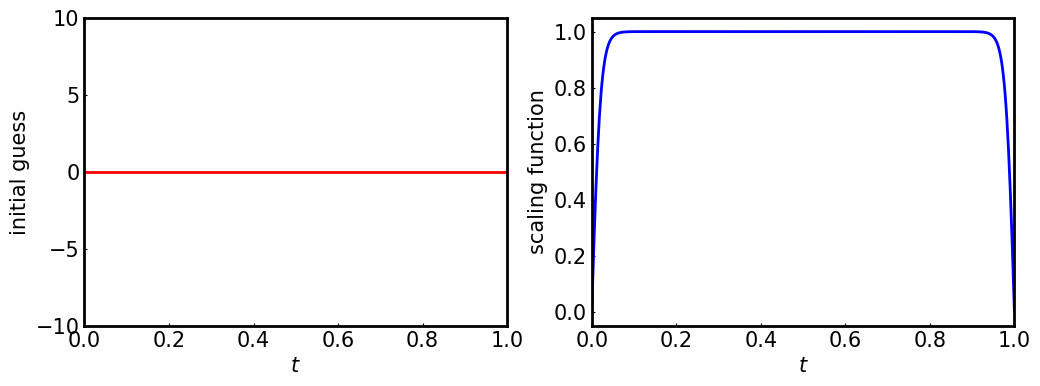

In [135]:
tlist = np.linspace(0, PULSE_DURATION, TIME_STEPS)

if opt_dict["pulses"][0]["initial_guess"]["function_type"] == "lambda_function":
    init_guess = eval(opt_dict["pulses"][0]["initial_guess"]["lambda_function"])(tlist)
else:
    init_guess = opt_dict["pulses"][0]["initial_guess"]["list_function"]

if opt_dict["pulses"][0]["scaling_function"]["function_type"] == "lambda_function":
    scaling_foo = eval(opt_dict["pulses"][0]["scaling_function"]["lambda_function"])(tlist)
else:
    scaling_foo = opt_dict["pulses"][0]["scaling_function"]["list_function"]

fig, axs = plt.subplots(1, 2, figsize = (12, 4))
axs : typing.List[plt.Axes]
ax = axs[0]
ax.plot(tlist, init_guess, c = "r")
ax.set_xlim(tlist[0], tlist[-1])
ax.set_ylim(opt_dict["pulses"][0]["lower_limit"],
            opt_dict["pulses"][0]["upper_limit"])
ax.set_xlabel(r"$t$")
ax.set_ylabel("initial guess")

ax = axs[1]
ax.plot(tlist, scaling_foo, c = "b")
ax.set_xlim(tlist[0], tlist[-1])
ax.set_xlabel(r"$t$")
ax.set_ylabel("scaling function")


---

### **Specifying the cost function**

In [121]:
def treat_control(control, tlist):
    def check_len():
        if len(control) != len(tlist):
            raise ValueError("Mismatched pulse and time bins.")
    
    if isinstance(control, np.ndarray):
        check_len()
        return control
    elif isinstance(control, list):
        check_len()
        return np.array(control)
    elif callable(control):
        return control(tlist)
    else:
        return np.array([control]*len(tlist))

sx = qt.sigmax()
sz = qt.sigmaz()
H_template = []
for i in range(N_QUBIT):
    ops = [qt.qeye(2)]*N_QUBIT
    ops_next = [qt.qeye(2)]*N_QUBIT
    
    ops[i] = sz
    if i == (N_QUBIT-1):
        ops_next[0] = sz
    else:
        ops_next[i+1] = sz
        
    sz_i = qt.tensor(*ops)
    sz_i_plus_1 = qt.tensor(*ops_next)
        
    H_template.append(-J*sz_i*sz_i_plus_1)
    
    ops[i] = sx
    sx_i = qt.tensor(*ops)
    
    H_template.append([sx_i, None])
    
def get_Ising_H(control):
    for i in range(N_QUBIT):
        H_template[2*i+1][1] = control
        
    return H_template
    
def get_cost_function(control,
                      plot_bloch = False):
    """
    control : numpy.ndarray
        The test control obtained in the given QOC iteration.
        
    plot_bloch : bool, default: False
        Whether to plot the Bloch sphere representation of the first-qubit partial-trace.
    """

    psi0 = qt.tensor(*[qt.basis(2, 0)]*3)
    psi_target = qt.tensor(*[qt.basis(2,1)]*3)
    
    tlist = np.linspace(0, PULSE_DURATION, TIME_STEPS)
    control = treat_control(control, tlist)
    
    H = get_Ising_H(control)
    
    rho_t = qt.mesolve(H = H,
                       tlist = tlist,
                       rho0 = psi0).states
    
    cf = qt.tracedist(rho_t[-1], psi_target)

    if plot_bloch:
        rho_0_t = []
        for i in range(len(tlist)):
            rho_0_t.append(qt.ptrace(rho_t[i], 0))
        b = qt.Bloch()
        b.add_annotation(qt.basis(2,1)*1.2, 
                         r"$d_\mathrm{tr}\left(\left|\psi_f\right\rangle, \left|\psi_\mathrm{target}\right\rangle\right)=%s$" % "%.6f" % cf)
        b.add_states(rho_0_t[1:-1], kind = "point", colors = ["b"]*(TIME_STEPS-2), alpha = 0.1)
        b.add_states(rho_0_t[0])
        b.add_states(rho_0_t[-1])
        b.show()
        
    return cf

class MyCostFunction(AbstractFoM):
    def get_FoM(self, pulses = [], parameters = [], timegrids = []):
        return {"FoM" : get_cost_function(pulses[0], plot_bloch=False)}


---

### **Performance of a rectangular pulse**

As a comparison, let us see the performance of a pulse with constant amplitude applied over the pulse duration. Other than the cost function value, we can also see the performance 

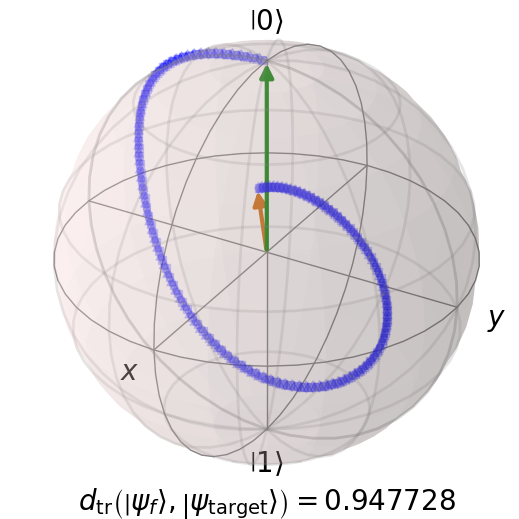

In [122]:
get_cost_function(np.pi, plot_bloch=True);


---

### **Running the optimization**

With the optimization dictionary and cost function correctly specified, we can now let QuOCS do the rest.

In [50]:
optimizer = Optimizer(opt_dict, MyCostFunction())
optimizer.execute()

shutil.rmtree(os.path.join(os.getcwd(), "QuOCS_Results"))

INFO     oc_logger    The optimization direction is minimization
INFO     oc_logger    Random number generator from the numpy library, version 1.26.4
INFO     oc_logger    QuOCS version number: 0.0.60
INFO     oc_logger    Direct search start time has been reset.
INFO     oc_logger    New record achieved. Previous FoM: 10000000000, new best FoM : 1.0
INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 1.0
INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 1.0000000180033866
INFO     oc_logger    New record achieved. Previous FoM: 1.0, new best FoM : 0.9999964177577898
INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.9999964177577898
INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.9999999468900855
INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 1.0000000063533663
INFO     oc_logger   


---

### **Getting the QOC results**

(0.0, 205.0)

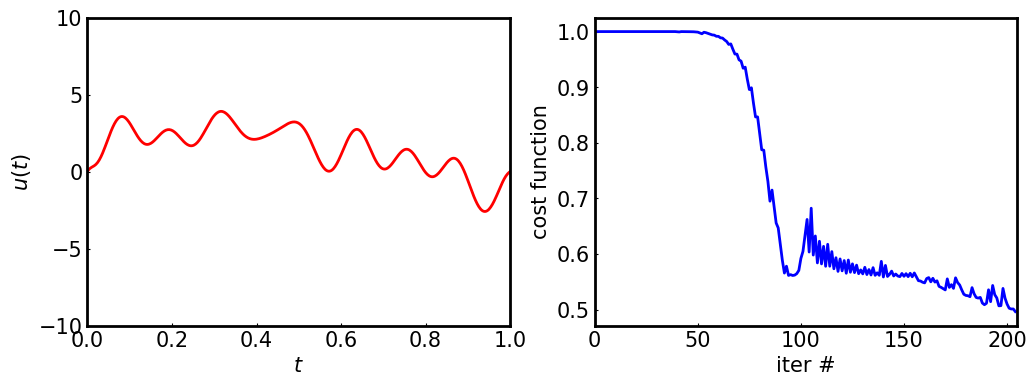

In [136]:
opt_alg = optimizer.get_optimization_algorithm()
tlist = opt_alg.get_best_controls()["timegrids"][0]
u_y_opt = opt_alg.get_best_controls()["pulses"][0]

cf_change = opt_alg.FoM_list

fig, axs = plt.subplots(1, 2, figsize = (12, 4))
axs : typing.List[plt.Axes]

ax = axs[0]
ax.plot(tlist, u_y_opt, c = "r")
ax.set_xlim(tlist[0], tlist[-1])
ax.set_ylim(opt_dict["pulses"][0]["lower_limit"],
            opt_dict["pulses"][0]["upper_limit"])
ax.set_ylabel(r"$u(t)$")
ax.set_xlabel(r"$t$")

ax = axs[1]
ax.plot(cf_change, c = "b")
ax.set_ylabel("cost function")
ax.set_xlabel("iter #")
ax.set_xlim(0, opt_alg.iteration_number)


---

### **Performance of the optimized control**

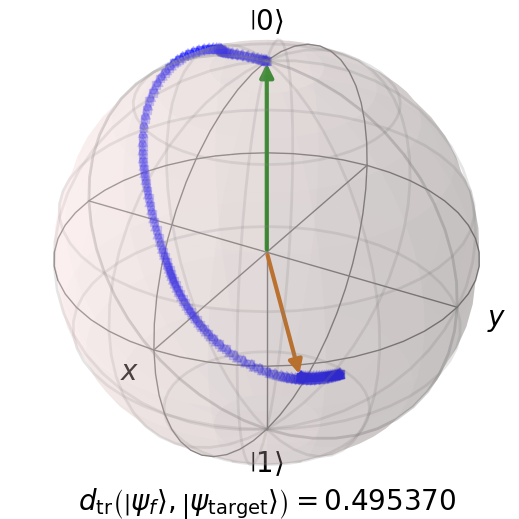

0.49536988591029024

In [123]:
get_cost_function(u_y_opt, True)